<a href="https://colab.research.google.com/github/comandi1969/AIFFEL_Online_Quest/blob/main/DLthon/CIFAR10_VGG16_%EA%B5%AC%ED%98%84_%EC%97%85%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81_128_No%EC%A6%9D%EA%B0%95_Nosteps_for_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 1. 데이터 로드
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [2]:
# CIFAR-10 클래스 이름
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [3]:
# 2. 데이터 전처리
# train_images = train_images / 255.0
# test_images = test_images / 255.0

# 이미지 업스케일링 128 X 128
# 이미지 업스케일링 데이터 정규화 불가
def resize_pil_images(images, target_height=128, target_width=128):
    """Resizes a batch of images using PIL."""
    resized_images = []
    for img in images:
        pil_img = Image.fromarray(img.astype(np.uint8))
        pil_img_resized = pil_img.resize((target_width, target_height), Image.BILINEAR)
        resized_images.append(np.array(pil_img_resized))
    return np.array(resized_images)

# Resize CIFAR-10 images
resized_train_images = resize_pil_images(train_images)
resized_test_images = resize_pil_images(test_images)

# resized_train_images = resized_train_images.astype('float32') / 255.0
# resized_test_images = resized_test_images.astype('float32') / 255.0

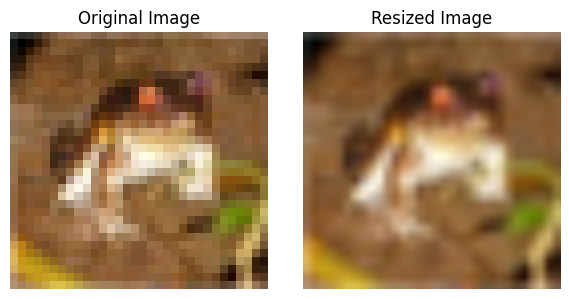

In [4]:
# Visualization function (same as before)
def plot_original_and_resized(original, resized, index):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(original[index].astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(resized[index].astype(np.uint8))
    plt.title('Resized Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize an example
plot_original_and_resized(train_images, resized_train_images, 0)

In [5]:
# 클래스 레이블을 원핫인코딩으로 변환
from tensorflow.keras.utils import to_categorical

num_classes = 10  # CIFAR-10은 10개의 클래스로 구성됨
train_labels_one_hot = to_categorical(train_labels, num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes)


In [6]:
# 4. 이미지 데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,      # 이미지 회전 범위 (도)
    width_shift_range=0.1,  # 수평 방향으로 이동 범위 (전체 너비의 비율)
    height_shift_range=0.1, # 수직 방향으로 이동 범위 (전체 높이의 비율)
    shear_range=0.1,        # 전단 변환 범위
    zoom_range=0.1,         # 확대/축소 범위
    horizontal_flip=True,   # 수평 방향으로 뒤집기
    fill_mode='nearest'     # 빈 공간을 어떻게 채울지 ('nearest', 'constant', 'reflect', 'wrap' 중 선택)
)
# datagen.fit(resized_train_images)

In [7]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
import os

# 로그 디렉터리 설정
log_dir = "./logs"
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint('cifar10_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.95  # decrease the learning rate after 10 epochs

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)


In [8]:
# VGG16 model for CIFAR10
model = Sequential([
    # First two convolutional layers
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Next two convolutional layers
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Next three convolutional layers
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Next three convolutional layers
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(10, activation='softmax')  # 10 classes for CIFAR10
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# steps_per_epoch 설정
# 데이터 파이프라인을 통해 2배의 훈련 데이터셋을 학습
# steps_per_epoch = (len(resized_train_images) // 128) * 2

# 학습, 원핫인코딩된 레이블로 레이블 바꿔주기
callbacks_list = [early_stopping, lr_scheduler]

#history = model.fit(datagen.flow(resized_train_images, train_labels_one_hot),
history = model.fit(resized_train_images, train_labels_one_hot,
                    batch_size = 128,
                    epochs=200,
#                    steps_per_epoch = steps_per_epoch,
                    validation_data=(resized_test_images, test_labels_one_hot),
                    shuffle=True,
                    callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

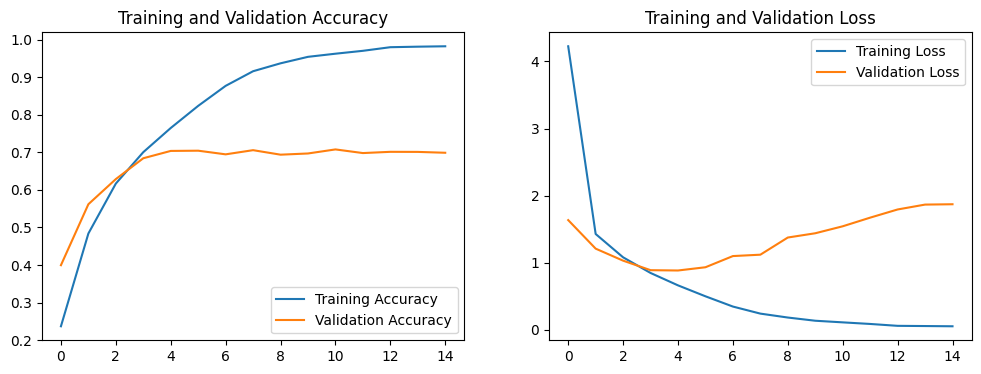

In [9]:
# 학습 및 검증 정확도와 손실을 그래프로 표시
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# 모델 학습 이후에 이 함수를 호출
plot_history(history)

313/313 [==============================] - 13s 36ms/step


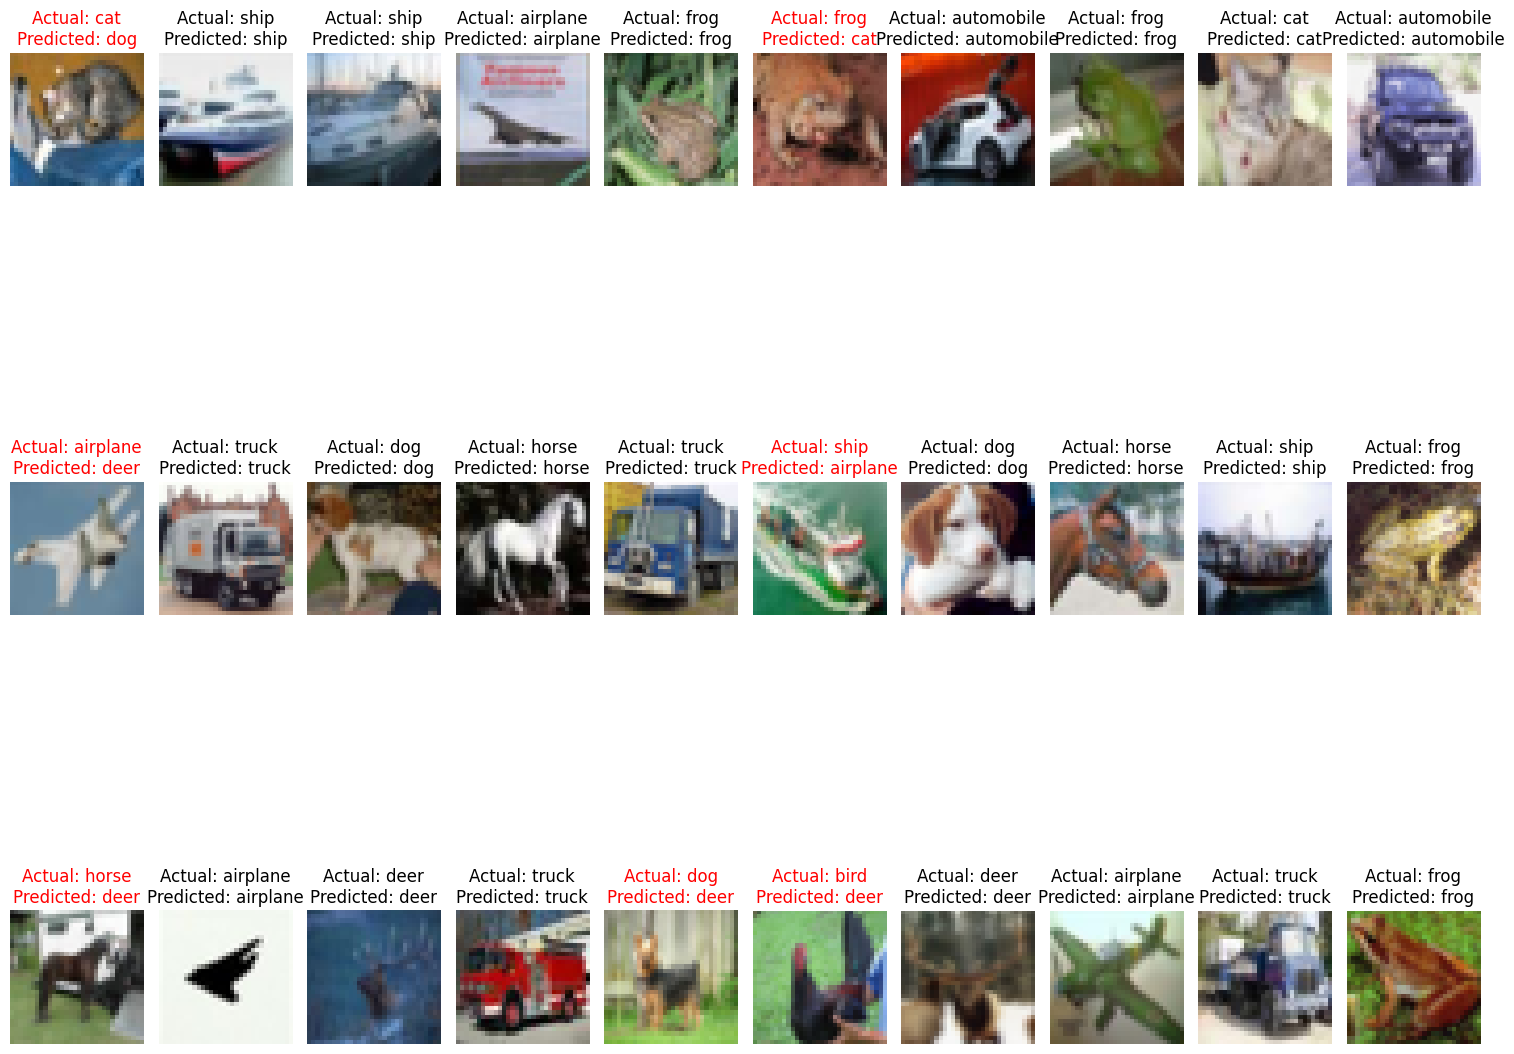

In [10]:
# 모델을 사용하여 예측한 클래스와 실제 클래스를 비교하는 이미지 시각화
def plot_predictions(images, labels, predictions, class_names, num=30, images_per_row=10):
    num_rows = (num + images_per_row - 1) // images_per_row
    plt.figure(figsize=(15, 5 * num_rows))
    for i in range(num):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(images[i])

        actual_class = class_names[labels[i][0]]
        predicted_class = class_names[np.argmax(predictions[i])]

        title = f"Actual: {actual_class}\nPredicted: {predicted_class}"
        if actual_class != predicted_class:
            title = f"Actual: {actual_class}\nPredicted: {predicted_class}"
            plt.title(title, color='red')  # 예측이 틀린 경우 빨간색 글자로 표시
        else:
            plt.title(title)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 모델을 사용하여 예측
predictions = model.predict(resized_test_images)

# 첫 30개 이미지에 대한 실제 클래스와 예측 클래스 시각화
plot_predictions(test_images, test_labels, predictions, class_names, num=30, images_per_row=10)
